In [1]:
import pandas as pd
import janitor

from utilities import pandas_to_tex, save_mpl_fig, load_visit_data, init_mpl_fig
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.3)

from constants import (
    filepaths,
    bl_measures_cumulative,
    palette7,
    linestyles7,
    var_labels,
)

## Prep data

In [2]:
df_blacklight = (
    pd.read_csv(filepaths["blacklight"])
    # Fix filename
    .assign(
        private_domain=lambda df_: df_["filename"].str.replace("_", ".", regex=False)
    )
    .remove_columns("filename")
    .reorder_columns(["private_domain"])
    .set_index("private_domain")
    .add_prefix("bl_")
    .reset_index()
)

df_blacklight

,private_domain,bl_ddg_join_ads,bl_third_party_cookies,bl_canvas_fingerprinting,bl_session_recording,bl_key_logging,bl_fb_pixel,bl_google_analytics
0,costarmanager.com,5,10,0,1,0,0,0
1,teasource.com,11,11,0,0,0,1,1
2,1800tequila.com,8,6,0,0,0,0,0
3,mazon.com,1,0,0,0,0,0,0
4,theancestorhunt.com,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
34073,methowtrails.org,1,0,0,0,0,0,0
34074,mistystoyaussies.com,4,6,0,0,0,0,0
34075,hellostarz.com,0,0,0,0,0,0,0
34076,kbdfans.com,5,7,0,0,0,0,1


In [3]:
df_visits = load_visit_data()
print(f"{len(df_visits)=:,}")
df_visits.head()

len(df_visits)=6,297,382


,caseid,private_domain,visit_time_local
0,205323077,google.com,2022-05-31 23:52:37
1,205323077,coupons.com,2022-06-01 01:07:35
2,205323077,google.com,2022-06-01 01:15:12
3,205323077,coupons.com,2022-06-01 01:16:07
4,205323077,google.com,2022-06-01 04:38:10


In [4]:
df_visits_process = (
    df_visits.dropna(subset=["private_domain"])
    # ==============================================================
    # Format time
    .assign(
        visit_time_local=lambda df_: pd.to_datetime(
            df_["visit_time_local"], format="mixed"
        ),
        visit_date=lambda df_: df_["visit_time_local"].dt.date,
        visit_hour=lambda df_: df_["visit_time_local"].dt.floor("H")
        #         ith_hour=lambda df_: ((df_["visit_time_local"] - df_["visit_time_local"].min()).dt.total_seconds() / 3600).astype(int)
    )
    # ==============================================================
    # Take the earliest ind-domain obs
    .sort_values(
        ["caseid", "private_domain", "visit_time_local"], ascending=(True, True, True)
    )
    .drop_duplicates(["caseid", "private_domain"], keep="first", ignore_index=True)
    # ==============================================================
    # Get trackers
    .merge(df_blacklight, how="left", on="private_domain", validate="m:1")
    .dropna(subset=bl_measures_cumulative, how="all", ignore_index=True)
    .remove_columns(["private_domain"])
)
df_visits_process

,caseid,visit_time_local,visit_date,visit_hour,bl_ddg_join_ads,bl_third_party_cookies,bl_canvas_fingerprinting,bl_session_recording,bl_key_logging,bl_fb_pixel,bl_google_analytics
0,47541,2022-06-18 13:35:16.000,2022-06-18,2022-06-18 13:00:00,62.0,53.0,0.0,0.0,0.0,0.0,0.0
1,47541,2022-06-01 22:43:59.000,2022-06-01,2022-06-01 22:00:00,17.0,26.0,0.0,0.0,0.0,1.0,0.0
2,47541,2022-06-11 10:26:33.000,2022-06-11,2022-06-11 10:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47541,2022-06-08 09:16:06.000,2022-06-08,2022-06-08 09:00:00,38.0,67.0,0.0,0.0,0.0,1.0,0.0
4,47541,2022-06-07 07:23:38.000,2022-06-07,2022-06-07 07:00:00,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
103848,343466645,2022-06-19 14:48:20.722,2022-06-19,2022-06-19 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103849,343466645,2022-06-17 13:30:24.000,2022-06-17,2022-06-17 13:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103850,343466645,2022-06-17 14:07:13.000,2022-06-17,2022-06-17 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103851,343466645,2022-06-18 04:33:50.000,2022-06-18,2022-06-18 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# number of visits before 1 Jun midnight
len(df_visits_process.query("visit_time_local <='2022-06-01'"))

3004

In [6]:
# number of caseid before 1 Jun midnight
df_visits_process.query("visit_time_local <='2022-06-01'")["caseid"].nunique()

493

In [7]:
df_visits_process.query("visit_time_local <='2022-05-31 17:00:00'")["caseid"].nunique()

4

In [8]:
df_visits_process.query("visit_time_local <='2022-05-31 18:00:00'")["caseid"].nunique()

52

In [9]:
df_visits_process["visit_time_local"].min()

Timestamp('2022-05-31 14:00:02')

In [10]:
df_visits_process["visit_time_local"].max()

Timestamp('2022-06-29 22:04:16')

In [11]:
n = df_visits_process["caseid"].nunique()
n

1132

## By Hours

In [21]:
df_visits_process

,caseid,visit_time_local,visit_date,visit_hour,bl_ddg_join_ads,bl_third_party_cookies,bl_canvas_fingerprinting,bl_session_recording,bl_key_logging,bl_fb_pixel,bl_google_analytics
0,47541,2022-06-18 13:35:16.000,2022-06-18,2022-06-18 13:00:00,62.0,53.0,0.0,0.0,0.0,0.0,0.0
1,47541,2022-06-01 22:43:59.000,2022-06-01,2022-06-01 22:00:00,17.0,26.0,0.0,0.0,0.0,1.0,0.0
2,47541,2022-06-11 10:26:33.000,2022-06-11,2022-06-11 10:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47541,2022-06-08 09:16:06.000,2022-06-08,2022-06-08 09:00:00,38.0,67.0,0.0,0.0,0.0,1.0,0.0
4,47541,2022-06-07 07:23:38.000,2022-06-07,2022-06-07 07:00:00,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
103848,343466645,2022-06-19 14:48:20.722,2022-06-19,2022-06-19 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103849,343466645,2022-06-17 13:30:24.000,2022-06-17,2022-06-17 13:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103850,343466645,2022-06-17 14:07:13.000,2022-06-17,2022-06-17 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103851,343466645,2022-06-18 04:33:50.000,2022-06-18,2022-06-18 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df_cum_prop_hours = pd.DataFrame(
    {
        "visit_hour": pd.date_range(
            "2022-05-31 14:00:00", "2022-06-29 23:00:00", freq="H"
        )
    }
)

for col in bl_measures_cumulative:
    # First hour each individual encountered this tracker
    first_exposure = (
        df_visits_process[df_visits_process[col] > 0]
        .groupby("caseid")["visit_hour"]
        .min()
        .reset_index(name="first_hour")
    )

    # Cumulative proportion up to each hour
    df_cum_prop_hours[f"{col}"] = df_cum_prop_hours["visit_hour"].apply(
        lambda h: (first_exposure["first_hour"] <= h).sum() / n
    )
df_cum_prop_hours.head(50)

,visit_hour,bl_ddg_join_ads,bl_third_party_cookies,bl_fb_pixel,bl_google_analytics,bl_session_recording,bl_key_logging,bl_canvas_fingerprinting
0,2022-05-31 14:00:00,0.001767,0.001767,0.000883,0.000000,0.000883,0.000000,0.001767
1,2022-05-31 15:00:00,0.001767,0.001767,0.000883,0.000883,0.000883,0.000883,0.001767
2,2022-05-31 16:00:00,0.003534,0.003534,0.001767,0.000883,0.000883,0.000883,0.001767
3,2022-05-31 17:00:00,0.039753,0.038869,0.014134,0.001767,0.005300,0.010601,0.014134
4,2022-05-31 18:00:00,0.067138,0.063604,0.025618,0.007067,0.012367,0.016784,0.026502
5,2022-05-31 19:00:00,0.131625,0.128092,0.043286,0.007951,0.022968,0.030919,0.040636
6,2022-05-31 20:00:00,0.273852,0.262367,0.108657,0.019435,0.056537,0.075088,0.099823
7,2022-05-31 21:00:00,0.339223,0.325972,0.144876,0.026502,0.073322,0.094523,0.123675
8,2022-05-31 22:00:00,0.384276,0.372792,0.178445,0.034452,0.098057,0.105124,0.141343
9,2022-05-31 23:00:00,0.406360,0.396643,0.197880,0.037102,0.105124,0.113958,0.150177


In [23]:
df_cum_prop_hours_long = df_cum_prop_hours.melt(
    id_vars="visit_hour", var_name="tracking_type", value_name="cumulative_proportion"
)
df_cum_prop_hours_long

,visit_hour,tracking_type,cumulative_proportion
0,2022-05-31 14:00:00,bl_ddg_join_ads,0.001767
1,2022-05-31 15:00:00,bl_ddg_join_ads,0.001767
2,2022-05-31 16:00:00,bl_ddg_join_ads,0.003534
3,2022-05-31 17:00:00,bl_ddg_join_ads,0.039753
4,2022-05-31 18:00:00,bl_ddg_join_ads,0.067138
...,...,...,...
4937,2022-06-29 19:00:00,bl_canvas_fingerprinting,0.918728
4938,2022-06-29 20:00:00,bl_canvas_fingerprinting,0.918728
4939,2022-06-29 21:00:00,bl_canvas_fingerprinting,0.918728
4940,2022-06-29 22:00:00,bl_canvas_fingerprinting,0.918728


In [24]:
df_zoom = df_cum_prop_hours_long[
    df_cum_prop_hours_long["visit_hour"].between("2022-05-31", "2022-06-03")
]
start_hour = df_zoom["visit_hour"].min()
start_hour = pd.to_datetime("2022-05-31 18:00:00")
df_zoom = df_zoom.assign(
    cumulative_hour=(df_zoom["visit_hour"] - start_hour).dt.total_seconds() / 3600
)
df_zoom

,visit_hour,tracking_type,cumulative_proportion,cumulative_hour
0,2022-05-31 14:00:00,bl_ddg_join_ads,0.001767,-4.0
1,2022-05-31 15:00:00,bl_ddg_join_ads,0.001767,-3.0
2,2022-05-31 16:00:00,bl_ddg_join_ads,0.003534,-2.0
3,2022-05-31 17:00:00,bl_ddg_join_ads,0.039753,-1.0
4,2022-05-31 18:00:00,bl_ddg_join_ads,0.067138,0.0
...,...,...,...,...
4290,2022-06-02 20:00:00,bl_canvas_fingerprinting,0.529152,50.0
4291,2022-06-02 21:00:00,bl_canvas_fingerprinting,0.531802,51.0
4292,2022-06-02 22:00:00,bl_canvas_fingerprinting,0.537102,52.0
4293,2022-06-02 23:00:00,bl_canvas_fingerprinting,0.541519,53.0


### Plot

In [25]:
hour_marks = [0, 12, 24, 36, 48]

df_hour_summ = (
    df_zoom.query("cumulative_hour in @hour_marks")
    .pivot_table(
        index="tracking_type", columns="cumulative_hour", values="cumulative_proportion"
    )
    .reindex(bl_measures_cumulative)
    .rename(index=var_labels)
    .round(3)
    .astype(str)
)
pandas_to_tex(df_hour_summ, "../tables/cum_exposure_by_hour", index=True)
df_hour_summ

cumulative_hour,0.0,12.0,24.0,36.0,48.0
tracking_type,,,,,
Ad Trackers,0.067,0.501,0.714,0.745,0.791
Third-Party Cookies,0.064,0.496,0.706,0.737,0.785
Facebook Pixel,0.026,0.258,0.476,0.526,0.598
Google Analytics,0.007,0.054,0.134,0.171,0.23
Session Recording,0.012,0.141,0.318,0.369,0.452
Keylogging,0.017,0.153,0.307,0.35,0.42
Canvas Fingerprinting,0.027,0.207,0.392,0.444,0.524


In [26]:
!cat "../tables/cum_exposure_by_hour.tex"

\midrule
Ad Trackers & 0.067 & 0.501 & 0.714 & 0.745 & 0.791 \\
Third-Party Cookies & 0.064 & 0.496 & 0.706 & 0.737 & 0.785 \\
Facebook Pixel & 0.026 & 0.258 & 0.476 & 0.526 & 0.598 \\
Google Analytics & 0.007 & 0.054 & 0.134 & 0.171 & 0.23 \\
Session Recording & 0.012 & 0.141 & 0.318 & 0.369 & 0.452 \\
Keylogging & 0.017 & 0.153 & 0.307 & 0.35 & 0.42 \\
Canvas Fingerprinting & 0.027 & 0.207 & 0.392 & 0.444 & 0.524 \\

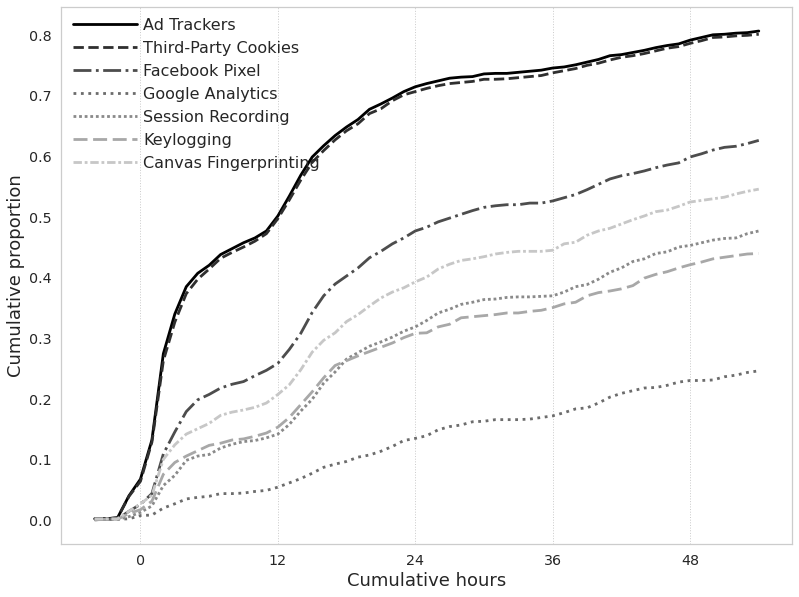

In [27]:
# plot
_, ax = init_mpl_fig((16, 12), 0.7)

# Plot each tracking_type without LOWESS
for ix, track_type in enumerate(df_zoom["tracking_type"].unique()):
    df_plot = df_zoom[df_zoom["tracking_type"] == track_type].copy()

    ax.plot(
        df_plot["cumulative_hour"],
        df_plot["cumulative_proportion"],
        label=var_labels[track_type],
        linewidth=2.8,
        linestyle=linestyles7[ix],
        color=palette7[ix],
    )

# Legend formatting
ax.legend(
    title="",
    fontsize=16,
    loc="upper left",
    frameon=False,
    borderpad=0.2,
    handlelength=4,
    handletextpad=0.4,
)

# ===============================================================
LABEL_SIZE = 18
ax.set_xlabel("Cumulative hours", fontsize=LABEL_SIZE)
ax.set_ylabel("Cumulative proportion", fontsize=LABEL_SIZE)
ax.set_xticks(hour_marks)

plt.grid(axis="x", linestyle=":")
plt.grid(axis="y", linestyle="")

plt.tight_layout()
save_mpl_fig("../figures/cum_exposure_by_hour")

## By days

In [28]:
df_cum_prop_days = pd.DataFrame(
    {"visit_date": pd.date_range("2022-05-31", "2022-06-29").date}
)

# Loop over each tracking type
for col in bl_measures_cumulative:
    # Find first date each person was exposed
    first_exposure = (
        df_visits_process[df_visits_process[col] > 0]
        .groupby("caseid")["visit_date"]
        .min()
        .reset_index(name="first_date")
    )

    # Calculate cumulative proportions per day
    df_cum_prop_days[f"{col}"] = df_cum_prop_days["visit_date"].apply(
        lambda d: (first_exposure["first_date"] <= d).sum() / n
    )
df_cum_prop_days

,visit_date,bl_ddg_join_ads,bl_third_party_cookies,bl_fb_pixel,bl_google_analytics,bl_session_recording,bl_key_logging,bl_canvas_fingerprinting
0,2022-05-31,0.406360,0.396643,0.197880,0.037102,0.105124,0.113958,0.150177
1,2022-06-01,0.730565,0.722615,0.509717,0.161661,0.358657,0.334806,0.430212
2,2022-06-02,0.803004,0.798587,0.620141,0.242933,0.471731,0.438163,0.541519
3,2022-06-03,0.839223,0.834806,0.688163,0.302120,0.550353,0.494700,0.612191
4,2022-06-04,0.851590,0.848057,0.719081,0.340106,0.588339,0.529152,0.650177
5,2022-06-05,0.865724,0.863074,0.745583,0.378975,0.621908,0.561837,0.677562
6,2022-06-06,0.878092,0.877208,0.771201,0.411661,0.658127,0.597173,0.711131
7,2022-06-07,0.889576,0.887809,0.790636,0.443463,0.686396,0.621025,0.739399
8,2022-06-08,0.907244,0.904594,0.812721,0.469081,0.715548,0.643110,0.761484
9,2022-06-09,0.923145,0.921378,0.834806,0.490283,0.744700,0.674912,0.779152


In [29]:
df_cum_prop_days_long = (
    df_cum_prop_days.assign(day=range(1, 31))
    .remove_columns("visit_date")
    .melt(id_vars="day", var_name="tracking_type", value_name="cumulative_proportion")
)
df_cum_prop_days_long

,day,tracking_type,cumulative_proportion
0,1,bl_ddg_join_ads,0.406360
1,2,bl_ddg_join_ads,0.730565
2,3,bl_ddg_join_ads,0.803004
3,4,bl_ddg_join_ads,0.839223
4,5,bl_ddg_join_ads,0.851590
...,...,...,...
205,26,bl_canvas_fingerprinting,0.910777
206,27,bl_canvas_fingerprinting,0.915194
207,28,bl_canvas_fingerprinting,0.916078
208,29,bl_canvas_fingerprinting,0.917845


### Plot

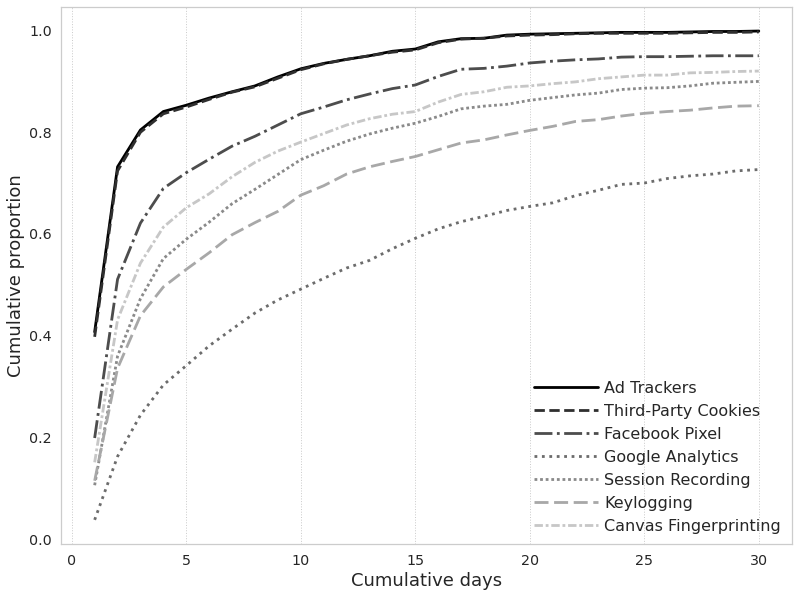

In [30]:
# plot
_, ax = init_mpl_fig((16, 12), 0.7)

# Plot each tracking_type without LOWESS
for ix, track_type in enumerate(df_cum_prop_days_long["tracking_type"].unique()):
    df_plot = df_cum_prop_days_long[
        df_cum_prop_days_long["tracking_type"] == track_type
    ].copy()

    ax.plot(
        df_plot["day"],
        df_plot["cumulative_proportion"],
        label=var_labels[track_type],
        linewidth=2.8,
        linestyle=linestyles7[ix],
        color=palette7[ix],
    )

# Legend formatting
ax.legend(
    title="",
    fontsize=16,
    loc="lower right",
    frameon=False,
    borderpad=0.2,
    handlelength=4,
    handletextpad=0.4,
)

# ===============================================================
LABEL_SIZE = 18
ax.set_xlabel("Cumulative days", fontsize=LABEL_SIZE)
ax.set_ylabel("Cumulative proportion", fontsize=LABEL_SIZE)

plt.grid(axis="x", linestyle=":")
plt.grid(axis="y", linestyle="")

plt.tight_layout()
save_mpl_fig("../figures/cum_exposure_by_day")